In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_params

from multi_group_simulation import MultiGroupSimulation

In [179]:
def get_cum_hosp(df):
    return df[['severity_3', 'severity_2']].iloc[df.shape[0] - 1].sum()

def get_cum_outside_infections(df):
    return df['cumulative_outside_infections'].iloc[df.shape[0] - 1].sum()

def get_cum_infections(df):
    return df[['cumulative_mild', 'cumulative_severe']].iloc[df.shape[0] - 1].sum()

def get_cum_inf_trajectory(df):
    return np.sum(df[['cumulative_mild', 'cumulative_severe']], axis=1)

def get_cum_hosp_trajectory(df):
    return np.sum(df[['severity_3', 'severity_2']], axis=1)

def get_cum_observed_inf_trajectory(df):
    return np.sum(df[['QI', 'R']], axis=1)

def get_cum_quarantine_isolation_trajectory(df):
    return np.sum(df[['QI','QS']], axis=1)

def get_cum_quarantine_trajectory(df):
    return df[['QS']]

def get_cum_isolation_trajectory(df):
    return df[['QI']]

def total_infections(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_infections(sim_df)
    return total

def total_hosp(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_hosp(sim_df)
    return total


In [3]:
# Fall Semester Group Config

# Loading group params
base_directory = '../src/simulations_v2/params/jan4calibration/'
# base_directory = '../src/simulations_v2/params/jan_12_send_to_mike/'

ug_ga_params = load_params(base_directory + 'group_1_students_post_movein_private.yaml')[1]
ug_other_params = load_params(base_directory + 'group_2_students_post_movein_private.yaml')[1]
gs_params = load_params(base_directory + 'group_3_students_post_movein_private.yaml')[1]
fs_params = load_params(base_directory + 'faculty_staff_post_movein_private.yaml')[1]
#params_list = [ug_ga_params.copy(), ug_other_params.copy(), gs_params.copy(), fs_params.copy()]
params_list = [ug_ga_params.copy(), ug_other_params.copy(), gs_params.copy()]

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [4]:
# Scaling of the interaction matrix is wrong, made up number of f/s -> f/s contact
interaction_matrix = 10 * np.array([[92/125, 1/44, 0],
                              [3.5/125, 6.5/44, 0],
                              [0,1/44,1/15]])

# adding population size
params_list[0]['population_size'] = 3533
params_list[1]['population_size'] = 8434
params_list[2]['population_size'] = 6202
#params_list[3]['population_size'] = 10000

for idx in range(3):
    params_list[idx]['daily_outside_infection_p'] *= 2
    params_list[idx]['expected_contacts_per_day'] = interaction_matrix[idx][idx]
#     params_list[idx]['test_protocol_QFNR'] = 1 - (0.75 * 0.95)

# Initially 12.4 free + infectious individuals (UG only)
UG_0_initial_cases = 5.69
UG_1_initial_cases = 13.15
UG_2_initial_cases = 6.52

params_list[0]['initial_ID_prevalence'] = UG_0_initial_cases / params_list[0]['population_size']
params_list[1]['initial_ID_prevalence'] = UG_1_initial_cases / params_list[1]['population_size']
params_list[2]['initial_ID_prevalence'] = UG_2_initial_cases / params_list[2]['population_size']

group_names = ['UG (Greek, Athlete)', 'UG (other)', 'GS']#, 'Faculty/Staff']

In [7]:
params_list[0]

{'severity_prevalence': array([0.47808584, 0.50907724, 0.00940271, 0.00343422]),
 'max_time_exposed': 7,
 'exposed_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_ID': 8,
 'ID_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_SyID_mild': 20,
 'SyID_mild_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_SyID_severe': 20,
 'SyID_severe_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'mild_symptoms_daily_self_report_p': 0,
 'cases_isolated_per_contact': 1.329,
 'cases_quarantined_per_contact': 3.304,
 'contact_trace_testing_frac': 1,
 'contact_tracing_delay': 1,
 'sample_QI_exit_function': <function analysis_helpers.binomial_exit_function.<locals>.<lambda>(n)>,
 'sample_QS_exit_function': <function analysis_helpers.binomial_exit_function.<locals>.<lambda>(n)>,
 'daily_outside_infection_p': 

In [5]:
from multiprocessing import Process
import pickle


def get_trajectories(transmission_p, n, T=19*7):
    
    for idx in range(3):
        params_list[idx]['exposed_infection_p'] = transmission_p
    
    sim = MultiGroupSimulation(params_list, interaction_matrix, group_names)

    trajectories = list()
    
    for _ in range(n):
        sim.run_new_trajectory(T)
        group_results = []
        for group in sim.sims:
            df = group.sim_df
            group_results.append(df)
        trajectories.append(group_results)

    return trajectories

def sim_target_f(transmission_p, ntrajectories, pickle_file_loc):
    results = get_trajectories(transmission_p, ntrajectories)
    pickle.dump(results, open(pickle_file_loc, "wb"))

def run_sims_new_process(transmission_p, ntrajectories, pickle_file_loc):
    p = Process(target = sim_target_f, args = (transmission_p, ntrajectories, pickle_file_loc))
    p.start()
    return p




In [6]:
base_transmission_p = 0.465/10
transmission_ps_to_try = [base_transmission_p * x for x in np.arange(1,3.51, 0.1)]

output_dir = "jan_19_multigroup_sim_results_spring/"
ntrajectories = 30

processes = []

for transmission_p in transmission_ps_to_try:
    filename = output_dir + "transmission_p_{}.pickle".format(transmission_p)
    p = run_sims_new_process(transmission_p, ntrajectories, filename)
    processes.append(p)
    
print("launched {} processes".format(len(processes)))
for p in processes:
    p.join()

launched 26 processes


In [31]:

def extract_sim_properties(fname):
    subname = fname.split('transmission_p_')[-1]
    subname = subname.split('.pickle')[0]
    return float(subname)

def load_sim_output(fname):
    with open(fname, "rb") as handle:
        sim_output = pickle.load(handle)
    return sim_output

def load_sim_outputs(sim_output_dir):
    sim_pickle_files = [sim_output_dir + '/' + file for  file in os.listdir(sim_output_dir) if '.pickle' in file]

    sim_outputs = {}
    for fname in sim_pickle_files:
        transmission_p = extract_sim_properties(fname)
        sim_output = load_sim_output(fname)
        sim_outputs[transmission_p] = sim_output

    print("Loaded {} simulation results".format(len(sim_outputs)))
    return sim_outputs

output_dir = "jan_13_multigroup_sim_results_send_to_mike/"
# output_dir = "jan_19_multigroup_sim_results_spring/"
sim_outputs = load_sim_outputs('./' + output_dir)

Loaded 26 simulation results


In [54]:
# output_dir = "jan_13_multigroup_sim_results_send_to_mike/"
# base_transmission_p = 0.24
# transmission_ps_to_try = [base_transmission_p * x for x in np.arange(1,3.51, 0.1)]
# sim_outputs = load_sim_outputs('./' + output_dir)

Loaded 26 simulation results


In [113]:
base_transmission_p = 0.465/10
transmission_ps_to_try = [base_transmission_p * x for x in np.arange(1,3.51, 0.1)]

output_dir = "jan_19_multigroup_sim_results_spring/"
sim_outputs = load_sim_outputs('./' + output_dir)

Loaded 26 simulation results


In [8]:
len(sim_outputs[base_transmission_p][0][0])

134

In [55]:
def get_avg_infxns_by_group(sim_output):
    infxns = sim_output
    infxns_by_group = {idx:0 for idx in range(3)}
    for trajectory_data in infxns:
        for idx in range(3):
            infxns_by_group[idx] += get_cum_infections(trajectory_data[idx]) / (len(infxns) * params_list[idx]['population_size'])
    return infxns_by_group


# def get_avg_hosps_by_group(sim_output):
#     infxns = sim_output[1]
#     infxns_by_group = {idx:0 for idx in range(3)}
#     for trajectory_data in infxns:
#         for idx in range(3):
#             infxns_by_group[idx] += trajectory_data[idx] / (len(infxns) * params_list[idx]['population_size'])
#     return infxns_by_group


avg_infxns_by_transmission_p = {}
# avg_hosps_by_transmission_p = {}
for t_p in sim_outputs:
    avg_infxns_by_transmission_p[t_p] = get_avg_infxns_by_group(sim_outputs[t_p])
#     avg_hosps_by_transmission_p[t_p] = get_avg_hosps_by_group(sim_outputs[t_p])

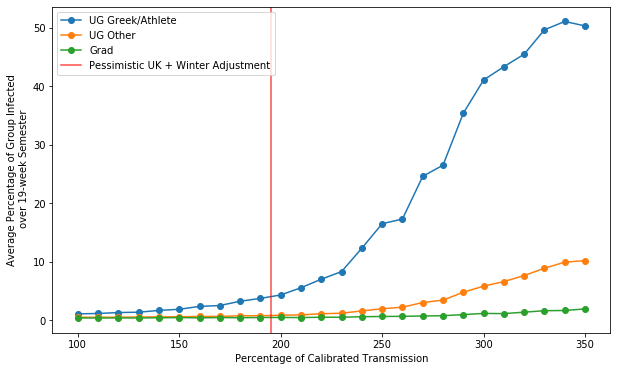

In [114]:
import matplotlib.pyplot as plt
%matplotlib inline

group_labels={0: 'UG Greek/Athlete', 1:'UG Other', 2:'Grad'}

plt.figure(figsize=(10,6))
for groupidx in range(3):
    group_infxns = []
    for t_p in transmission_ps_to_try:
        group_infxns.append(avg_infxns_by_transmission_p[t_p][groupidx] * 100)
    plt.plot([100 * t_p / base_transmission_p for t_p in transmission_ps_to_try], 
             group_infxns, marker='o', label=group_labels[groupidx])
plt.axvline(1.56*1.25*100, label='Pessimistic UK + Winter Adjustment', color='red', alpha=0.7)
plt.legend(loc='best')
plt.xlabel('Percentage of Calibrated Transmission')
plt.ylabel('Average Percentage of Group Infected\n over 19-week Semester')
plt.show()

In [116]:
for groupidx in range(3):
    group_infxns = []
    for t_p in transmission_ps_to_try:
        group_infxns.append(avg_infxns_by_transmission_p[t_p][groupidx] * 100)
    print(group_infxns[-1])

50.317011038777224
10.154138012805312
1.8881006127055788


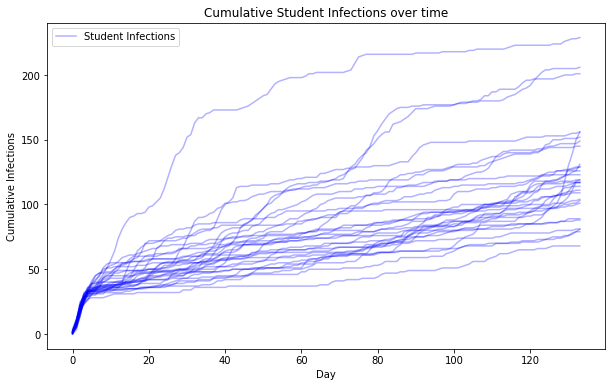

In [11]:
plt.figure(figsize=(10,6))

label = True

for sim_run in sim_outputs[base_transmission_p]:
    if label:
        (get_cum_inf_trajectory(sim_run[0]) + get_cum_inf_trajectory(sim_run[1]) + get_cum_inf_trajectory(sim_run[2])).plot(color='blue', alpha=0.3, label='Student Infections')
        label=False
        plt.legend(loc='best')
    else:
        (get_cum_inf_trajectory(sim_run[0]) + get_cum_inf_trajectory(sim_run[1]) + get_cum_inf_trajectory(sim_run[2])).plot(color='blue', alpha=0.3)

plt.xlabel('Day')
plt.ylabel('Cumulative Infections')
plt.title('Cumulative Student Infections over time')
        
plt.show()

In [33]:
sim_outputs.keys()

dict_keys([0.7920000000000005, 0.7680000000000005, 0.8400000000000005, 0.8160000000000005, 0.6480000000000004, 0.6720000000000004, 0.7200000000000004, 0.5040000000000002, 0.7440000000000004, 0.6960000000000004, 0.5280000000000002, 0.6000000000000003, 0.3600000000000001, 0.4800000000000002, 0.6240000000000003, 0.5760000000000003, 0.40800000000000014, 0.31200000000000006, 0.264, 0.5520000000000003, 0.4560000000000002, 0.43200000000000016, 0.24, 0.3840000000000001, 0.3360000000000001, 0.28800000000000003])

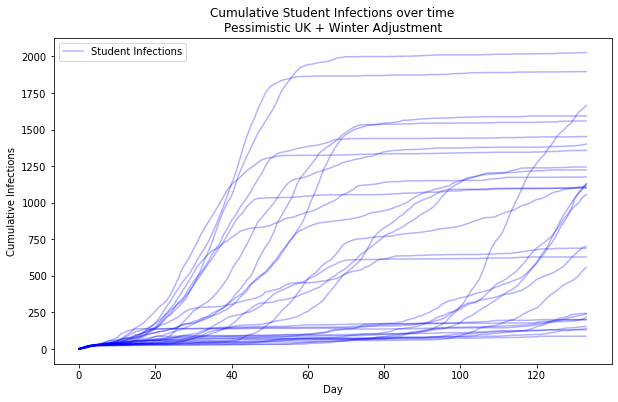

In [57]:
plt.figure(figsize=(10,6))

label = True

for sim_run in sim_outputs[0.4800000000000002]:
    if label:
        (get_cum_inf_trajectory(sim_run[0]) + get_cum_inf_trajectory(sim_run[1]) + get_cum_inf_trajectory(sim_run[2])).plot(color='blue', alpha=0.3, label='Student Infections')
        label=False
        plt.legend(loc='best')
    else:
        (get_cum_inf_trajectory(sim_run[0]) + get_cum_inf_trajectory(sim_run[1]) + get_cum_inf_trajectory(sim_run[2])).plot(color='blue', alpha=0.3)

plt.xlabel('Day')
plt.ylabel('Cumulative Infections')
plt.title('Cumulative Student Infections over time\nPessimistic UK + Winter Adjustment')
        
plt.show()

In [58]:
infs = list()
for sim_run in sim_outputs[0.4800000000000002]:
    infs.append(list(get_cum_inf_trajectory(sim_run[0]) + get_cum_inf_trajectory(sim_run[1]) + get_cum_inf_trajectory(sim_run[2]))[-1])
    
np.median(infs)

1102.5

# use 3/7 surveillance testing

In [15]:
base_transmission_p = 0.465/10
transmission_ps_to_try = [base_transmission_p * x for x in np.arange(1,3.51, 0.1)]

params_list[0]['test_population_fraction'] = 3/7

output_dir = "jan_19_multigroup_sim_results_spring_higher_surveillance/"
ntrajectories = 30

processes = []

for transmission_p in transmission_ps_to_try:
    filename = output_dir + "transmission_p_{}.pickle".format(transmission_p)
    p = run_sims_new_process(transmission_p, ntrajectories, filename)
    processes.append(p)
    
print("launched {} processes".format(len(processes)))
for p in processes:
    p.join()

launched 26 processes


In [91]:
output_dir = "jan_13_multigroup_sim_results_send_to_mike_higher_surveillance/"
base_transmission_p = 0.24
transmission_ps_to_try = [base_transmission_p * x for x in np.arange(1,3.51, 0.1)]
sim_outputs = load_sim_outputs('./' + output_dir)

Loaded 26 simulation results


In [99]:
output_dir = "jan_19_multigroup_sim_results_spring_higher_surveillance/"
base_transmission_p = 0.465/10
transmission_ps_to_try = [base_transmission_p * x for x in np.arange(1,3.51, 0.1)]
sim_outputs = load_sim_outputs('./' + output_dir)

Loaded 26 simulation results


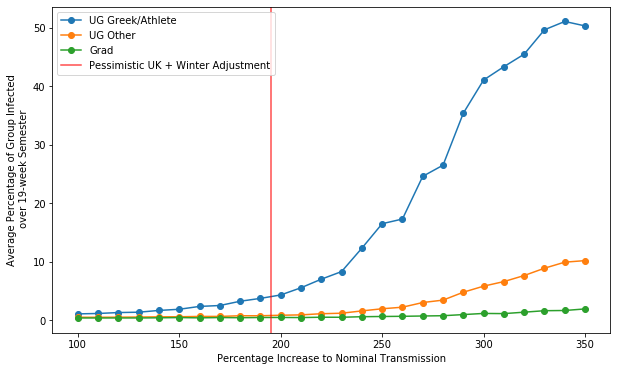

In [112]:
# sim_outputs = load_sim_outputs('./' + output_dir)
avg_infxns_by_transmission_p = {}
# avg_hosps_by_transmission_p = {}
for t_p in sim_outputs:
    avg_infxns_by_transmission_p[t_p] = get_avg_infxns_by_group(sim_outputs[t_p])
#     avg_hosps_by_transmission_p[t_p] = get_avg_hosps_by_group(sim_outputs[t_p])
plt.figure(figsize=(10,6))
for groupidx in range(3):
    group_infxns = []
    for t_p in transmission_ps_to_try:
        group_infxns.append(avg_infxns_by_transmission_p[t_p][groupidx] * 100)
    plt.plot([100 * t_p / base_transmission_p for t_p in transmission_ps_to_try], 
             group_infxns, marker='o', label=group_labels[groupidx])
plt.axvline(1.56*1.25*100, label='Pessimistic UK + Winter Adjustment', color='red', alpha=0.7)
plt.legend(loc='best')
plt.xlabel('Percentage Increase to Nominal Transmission')
plt.ylabel('Average Percentage of Group Infected\n over 19-week Semester')
plt.show()

In [48]:
sim_outputs.keys()
# base_transmission_p = 0.265

dict_keys([0.8400000000000005, 0.8160000000000005, 0.7680000000000005, 0.7440000000000004, 0.7920000000000005, 0.6480000000000004, 0.7200000000000004, 0.5520000000000003, 0.6240000000000003, 0.6960000000000004, 0.5760000000000003, 0.5280000000000002, 0.4560000000000002, 0.40800000000000014, 0.6720000000000004, 0.5040000000000002, 0.43200000000000016, 0.6000000000000003, 0.4800000000000002, 0.3600000000000001, 0.3360000000000001, 0.31200000000000006, 0.28800000000000003, 0.264, 0.3840000000000001, 0.24])

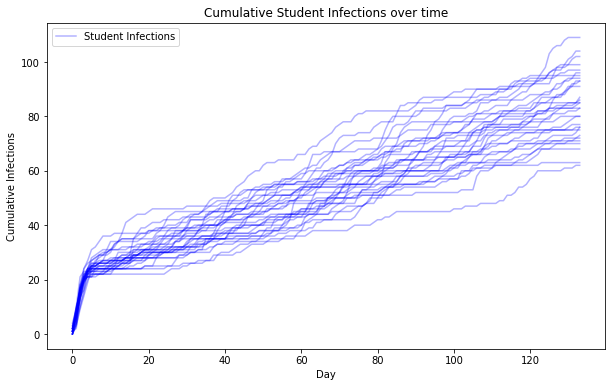

In [38]:
plt.figure(figsize=(10,6))

label = True

for sim_run in sim_outputs[base_transmission_p]:
    if label:
        (get_cum_inf_trajectory(sim_run[0]) + get_cum_inf_trajectory(sim_run[1]) + get_cum_inf_trajectory(sim_run[2])).plot(color='blue', alpha=0.3, label='Student Infections')
        label=False
        plt.legend(loc='best')
    else:
        (get_cum_inf_trajectory(sim_run[0]) + get_cum_inf_trajectory(sim_run[1]) + get_cum_inf_trajectory(sim_run[2])).plot(color='blue', alpha=0.3)

plt.xlabel('Day')
plt.ylabel('Cumulative Infections')
plt.title('Cumulative Student Infections over time')
        
plt.show()

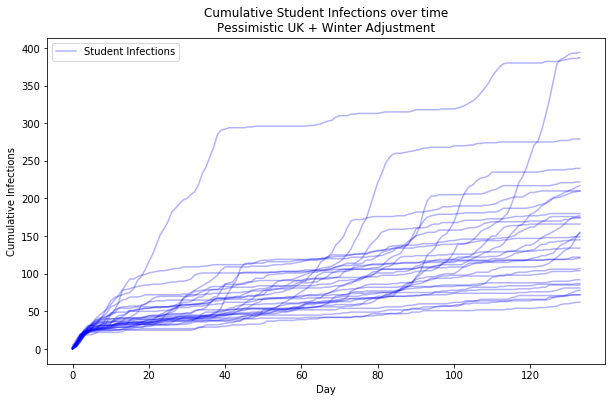

In [53]:
plt.figure(figsize=(10,6))

label = True

for sim_run in sim_outputs[0.4800000000000002]:
    if label:
        (get_cum_inf_trajectory(sim_run[0]) + get_cum_inf_trajectory(sim_run[1]) + get_cum_inf_trajectory(sim_run[2])).plot(color='blue', alpha=0.3, label='Student Infections')
        label=False
        plt.legend(loc='best')
    else:
        (get_cum_inf_trajectory(sim_run[0]) + get_cum_inf_trajectory(sim_run[1]) + get_cum_inf_trajectory(sim_run[2])).plot(color='blue', alpha=0.3)

plt.xlabel('Day')
plt.ylabel('Cumulative Infections')
plt.title('Cumulative Student Infections over time\nPessimistic UK + Winter Adjustment')
        
plt.show()

In [50]:
# params_list[0]
infs = list()
for sim_run in sim_outputs[0.4800000000000002]:
    infs.append(list(get_cum_inf_trajectory(sim_run[0]) + get_cum_inf_trajectory(sim_run[1]) + get_cum_inf_trajectory(sim_run[2]))[-1])
    
np.median(infs)

151.5

## Plotting 2x/week and 3x/week (all students combined)

### V1 (messy)

In [135]:
def get_avg_infxns(sim_output):
    infxns = sim_output
    pop_size = 0
    for idx in range(3):
        pop_size += params_list[idx]['population_size']
    inf_traj = 0
    for trajectory_data in infxns:
        for idx in range(3):
            inf_traj += get_cum_infections(trajectory_data[idx]) / (len(infxns) * pop_size)
#             inf_traj += get_cum_infections(trajectory_data[idx]) / (len(infxns))
    return inf_traj

In [123]:
sim_outputs.keys()
get_avg_infxns(sim_outputs[0.0465])
# get_cum_infections(sim_outputs[0.0465][0][0])

18169


96.93333333333334

Loaded 26 simulation results
[0.6878015667712403, 0.7408222797071937, 1.0587630946483935, 1.1725099528500929, 1.445318949859652, 1.9947896600436636, 2.96567413359752, 3.9947162749738565, 5.797787440145302, 7.676261764544005, 9.991377254297612, 11.330838240959874, 13.271506412020473, 13.848129598033282, 14.553360118883822, 15.392151466784082, 15.859981286807193, 16.3500100904471, 16.879850294457594, 17.691122241180032, 17.858807125690277, 18.794650228411033, 19.395857412809363, 19.92349606472564, 20.88263892711028, 21.31120773478636]
Loaded 26 simulation results


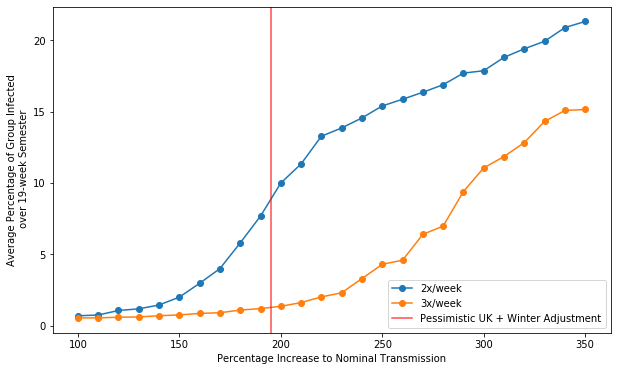

In [136]:
# 2x/week

output_dir = "jan_19_multigroup_sim_results_spring/"
base_transmission_p = 0.465/10
transmission_ps_to_try = [base_transmission_p * x for x in np.arange(1,3.51, 0.1)]
sim_outputs = load_sim_outputs('./' + output_dir)

avg_infxns_by_transmission_p = {}
for t_p in sim_outputs:
    avg_infxns_by_transmission_p[t_p] = get_avg_infxns(sim_outputs[t_p])
plt.figure(figsize=(10,6))

total_infxns = []
for t_p in transmission_ps_to_try:
    total_infxns.append(avg_infxns_by_transmission_p[t_p] * 100)
plt.plot([100 * t_p / base_transmission_p for t_p in transmission_ps_to_try], 
         total_infxns, marker='o', label='2x/week')

# 3x / week

output_dir = "jan_19_multigroup_sim_results_spring_higher_surveillance/"
base_transmission_p = 0.465/10
transmission_ps_to_try = [base_transmission_p * x for x in np.arange(1,3.51, 0.1)]
sim_outputs = load_sim_outputs('./' + output_dir)

avg_infxns_by_transmission_p = {}
for t_p in sim_outputs:
    avg_infxns_by_transmission_p[t_p] = get_avg_infxns(sim_outputs[t_p])

total_infxns = []
for t_p in transmission_ps_to_try:
    total_infxns.append(avg_infxns_by_transmission_p[t_p] * 100)
plt.plot([100 * t_p / base_transmission_p for t_p in transmission_ps_to_try], 
         total_infxns, marker='o', label='3x/week')


plt.axvline(1.56*1.25*100, label='Pessimistic UK + Winter Adjustment', color='red', alpha=0.7)
plt.legend(loc='best')
plt.xlabel('Percentage Increase to Nominal Transmission')
plt.ylabel('Average Percentage of Group Infected\n over 19-week Semester')
plt.show()

### V2 (cleaner)

Loaded 26 simulation results
[3533, 8434, 6202]
[124.96666666666667, 134.60000000000002, 192.36666666666667, 213.0333333333333, 262.6, 362.43333333333334, 538.8333333333334, 725.8000000000001, 1053.4, 1394.6999999999998, 1815.3333333333333, 2058.7, 2411.3, 2516.066666666667, 2644.2, 2796.5999999999995, 2881.5999999999995, 2970.633333333333, 3066.9, 3214.3, 3244.766666666667, 3414.800000000001, 3524.0333333333338, 3619.8999999999996, 3794.1666666666656, 3872.0333333333333]
Loaded 26 simulation results


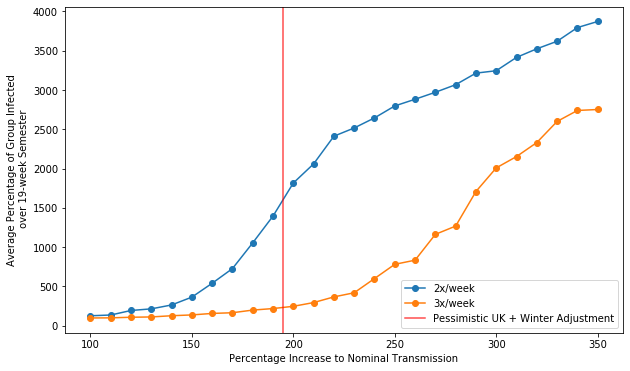

In [141]:
# 2x / week
output_dir = "jan_19_multigroup_sim_results_spring/"
base_transmission_p = 0.465/10
transmission_ps_to_try = [base_transmission_p * x for x in np.arange(1,3.51, 0.1)]
sim_outputs = load_sim_outputs('./' + output_dir)

avg_infxns_by_transmission_p = {}
wts = []
for idx in range(3):
    wts.append(params_list[idx]['population_size'])
print(wts)
    
for t_p in sim_outputs:
    data = get_avg_infxns_by_group(sim_outputs[t_p])
    avg_infxns_by_transmission_p[t_p] = np.dot([data[0],data[1],data[2]], wts)

plt_data = []
for t_p in transmission_ps_to_try:
    plt_data.append(avg_infxns_by_transmission_p[t_p])

print(plt_data)
    
plt.figure(figsize=(10,6))
        
plt.plot([100 * t_p / base_transmission_p for t_p in transmission_ps_to_try], 
             plt_data, marker='o', label='2x/week')

# 3x/week

output_dir = "jan_19_multigroup_sim_results_spring_higher_surveillance/"
sim_outputs = load_sim_outputs('./' + output_dir)

avg_infxns_by_transmission_p = {}
wts = []
for idx in range(3):
    wts.append(params_list[idx]['population_size'])
for t_p in sim_outputs:
    data = get_avg_infxns_by_group(sim_outputs[t_p])
    avg_infxns_by_transmission_p[t_p] = np.dot([data[0],data[1],data[2]], wts)

plt_data = []
for t_p in transmission_ps_to_try:
    plt_data.append(avg_infxns_by_transmission_p[t_p])

plt.plot([100 * t_p / base_transmission_p for t_p in transmission_ps_to_try], 
             plt_data, marker='o', label='3x/week')


plt.axvline(1.56*1.25*100, label='Pessimistic UK + Winter Adjustment', color='red', alpha=0.7)
plt.legend(loc='best')
plt.xlabel('Percentage Increase to Nominal Transmission')
plt.ylabel('Average Percentage of Group Infected\n over 19-week Semester')
plt.show()

# Quarantine / Isolation Requirements

### Results from previous sims

In [26]:
output_dir = "jan_13_multigroup_sim_results_send_to_mike/"
sim_outputs = load_sim_outputs('./' + output_dir)

Loaded 26 simulation results


In [27]:
def get_Q_trajectories(sim_output):
    Q_data = sim_output
    Q_trajectories = list()
    Q_trajectories_UG = list()
    for trajectory_data in Q_data:
        Q_trajectories.append(np.sum(trajectory_data[0][['QI','QS']], axis=1) + np.sum(trajectory_data[1][['QI','QS']], axis=1) + np.sum(trajectory_data[2][['QI','QS']], axis=1))
        Q_trajectories_UG.append(np.sum(trajectory_data[0][['QI','QS']], axis=1) + np.sum(trajectory_data[1][['QI','QS']], axis=1))
#         for idx in range(3):
#             Q_by_group[idx] += get_cum_infections(trajectory_data[idx]) / (len(Q_data) * params_list[idx]['population_size'])
    return Q_trajectories, Q_trajectories_UG

q_trajs, q_trajs_UG = get_Q_trajectories(sim_outputs[0.4800000000000002])


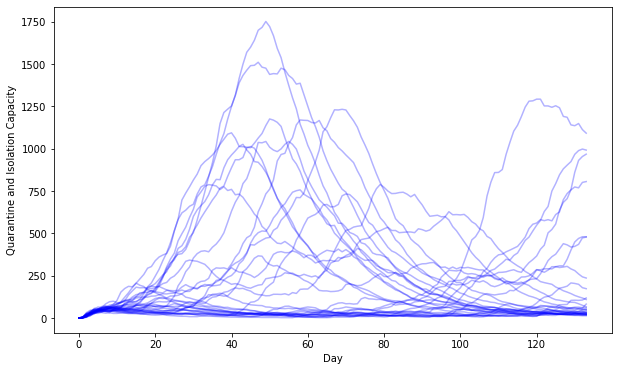

In [28]:
# plotting trajectories
plt.figure(figsize=(10,6))
for traj in q_trajs:
    plt.plot(traj, alpha=0.3, color='blue')
plt.xlabel('Day')
plt.ylabel('Quarantine and Isolation Capacity')
plt.show()

In [29]:
# q_trajs[0][:38], q_trajs[0][38:]
max_arrival = list()
max_steady_state = list()
for traj in q_trajs_UG:
    max_arrival.append(np.max(traj[:38]))
    max_steady_state.append(np.max(traj[38:]))

print(np.quantile(max_arrival,0.95), np.quantile(max_steady_state,0.95))
print(np.max(max_arrival), np.max(max_steady_state))

836.6000000000003 1235.0000000000002
1144.0 1747.0


### Running more sims

##### 2/7 testing

In [21]:
base_transmission_p = 0.465/10
# transmission_ps_to_try = [base_transmission_p * x for x in np.arange(1,3.51, 0.1)]

spring_transmission_p = base_transmission_p * 1.56 * 1.25

params_list[0]['test_population_fraction'] = 2/7

output_dir = "jan_19_multigroup_quarantine_twice_weekly_testing/"
ntrajectories = 250

processes = []

for transmission_p in [spring_transmission_p]:
    filename = output_dir + "transmission_p_{}.pickle".format(transmission_p)
    p = run_sims_new_process(transmission_p, ntrajectories, filename)
    processes.append(p)
    
print("launched {} processes".format(len(processes)))
for p in processes:
    p.join()

launched 1 processes


In [75]:
base_transmission_p = 0.465/10
spring_transmission_p = base_transmission_p * 1.56 * 1.25
output_dir = "jan_19_multigroup_quarantine_twice_weekly_testing/"
sim_outputs = load_sim_outputs('./' + output_dir)

Loaded 1 simulation results


In [76]:
def get_Q_trajectories(sim_output):
    Q_data = sim_output
    Q_trajectories = list()
    Q_trajectories_UG = list()
    for trajectory_data in Q_data:
        Q_trajectories.append(np.sum(trajectory_data[0][['QI','QS']], axis=1) + np.sum(trajectory_data[1][['QI','QS']], axis=1) + np.sum(trajectory_data[2][['QI','QS']], axis=1))
        Q_trajectories_UG.append(np.sum(trajectory_data[0][['QI','QS']], axis=1) + np.sum(trajectory_data[1][['QI','QS']], axis=1))
#         for idx in range(3):
#             Q_by_group[idx] += get_cum_infections(trajectory_data[idx]) / (len(Q_data) * params_list[idx]['population_size'])
    return Q_trajectories, Q_trajectories_UG

q_trajs, q_trajs_UG = get_Q_trajectories(sim_outputs[spring_transmission_p])


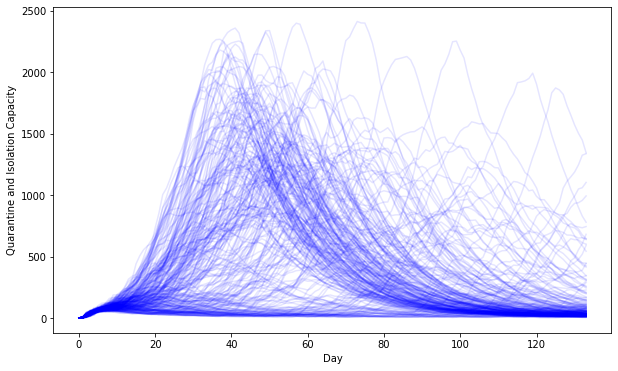

In [77]:
# plotting trajectories
plt.figure(figsize=(10,6))
for traj in q_trajs:
    plt.plot(traj, alpha=0.1, color='blue')
plt.xlabel('Day')
plt.ylabel('Quarantine and Isolation Capacity')
plt.show()

In [78]:
# q_trajs[0][:38], q_trajs[0][38:]
max_arrival = list()
max_steady_state = list()
for traj in q_trajs:
    max_arrival.append(np.max(traj[:38]))
    max_steady_state.append(np.max(traj[38:]))

print(np.quantile(max_arrival,0.95), np.quantile(max_steady_state,0.95))
print(np.max(max_arrival), np.max(max_steady_state))

1907.2999999999997 2148.55
2268.0 2413.0


##### Testing Greek / Athlete 3x a week


In [68]:
base_transmission_p = 0.465/10
# transmission_ps_to_try = [base_transmission_p * x for x in np.arange(1,3.51, 0.1)]

spring_transmission_p = base_transmission_p * 1.56 * 1.25

params_list[0]['test_population_fraction'] = 3/7

output_dir = "jan_19_multigroup_quarantine_three_weekly_testing/"
ntrajectories = 250

processes = []

for transmission_p in [spring_transmission_p]:
    filename = output_dir + "transmission_p_{}.pickle".format(transmission_p)
    p = run_sims_new_process(transmission_p, ntrajectories, filename)
    processes.append(p)
    
print("launched {} processes".format(len(processes)))
for p in processes:
    p.join()

launched 1 processes


In [69]:
output_dir = "jan_19_multigroup_quarantine_three_weekly_testing/"
sim_outputs = load_sim_outputs('./' + output_dir)

Loaded 1 simulation results


In [70]:
def get_Q_trajectories(sim_output):
    Q_data = sim_output
    Q_trajectories = list()
    Q_trajectories_UG = list()
    for trajectory_data in Q_data:
        Q_trajectories.append(np.sum(trajectory_data[0][['QI','QS']], axis=1) + np.sum(trajectory_data[1][['QI','QS']], axis=1) + np.sum(trajectory_data[2][['QI','QS']], axis=1))
        Q_trajectories_UG.append(np.sum(trajectory_data[0][['QI','QS']], axis=1) + np.sum(trajectory_data[1][['QI','QS']], axis=1))
#         for idx in range(3):
#             Q_by_group[idx] += get_cum_infections(trajectory_data[idx]) / (len(Q_data) * params_list[idx]['population_size'])
    return Q_trajectories, Q_trajectories_UG

q_trajs, q_trajs_UG = get_Q_trajectories(sim_outputs[spring_transmission_p])


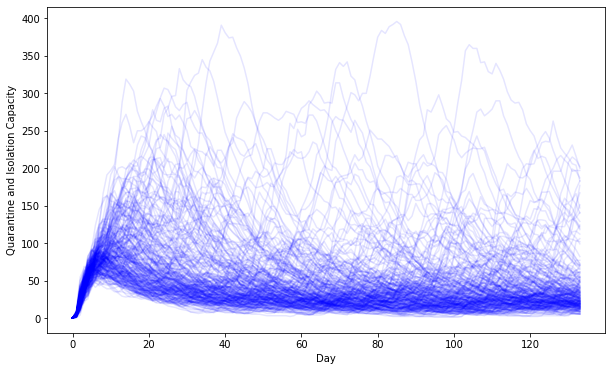

In [71]:
# plotting trajectories
plt.figure(figsize=(10,6))
for traj in q_trajs:
    plt.plot(traj, alpha=0.1, color='blue')
plt.xlabel('Day')
plt.ylabel('Quarantine and Isolation Capacity')
plt.show()

In [72]:
# UG trajectories
np.random.seed(2050)
# q_trajs[0][:38], q_trajs[0][38:]
max_arrival = list()
max_steady_state = list()
for traj in q_trajs_UG:
    max_arrival.append(np.random.poisson(43.8) + np.max(traj[:38]))
    max_steady_state.append(np.max(traj[38:]))

print(np.quantile(max_arrival,0.95), np.quantile(max_steady_state,0.95))
print(np.max(max_arrival), np.max(max_steady_state))

270.7499999999999 253.09999999999997
395.0 384.0


In [73]:
# All student trajectories
np.random.seed(2060)
max_arrival = list()
max_steady_state = list()
for traj in q_trajs:
    max_arrival.append(np.random.poisson(47.9) + np.max(traj[:38]))
    max_steady_state.append(np.max(traj[38:]))

print(np.quantile(max_arrival,0.95), np.quantile(max_steady_state,0.95))
print(np.max(max_arrival), np.max(max_steady_state))

292.04999999999984 260.2999999999999
401.0 396.0


In [74]:
params_list[0]

{'severity_prevalence': array([0.47808584, 0.50907724, 0.00940271, 0.00343422]),
 'max_time_exposed': 7,
 'exposed_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_ID': 8,
 'ID_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_SyID_mild': 20,
 'SyID_mild_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_SyID_severe': 20,
 'SyID_severe_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'mild_symptoms_daily_self_report_p': 0,
 'cases_isolated_per_contact': 1.329,
 'cases_quarantined_per_contact': 3.304,
 'contact_trace_testing_frac': 1,
 'contact_tracing_delay': 1,
 'sample_QI_exit_function': <function analysis_helpers.binomial_exit_function.<locals>.<lambda>(n)>,
 'sample_QS_exit_function': <function analysis_helpers.binomial_exit_function.<locals>.<lambda>(n)>,
 'daily_outside_infection_p': 

# Trajectories

In [145]:
transmission_elevation_factor = 1.56
base_transmission_p = 0.465/10
# transmission_ps_to_try = [base_transmission_p * x for x in np.arange(1,3.51, 0.1)]

params_list[0]['test_population_fraction'] = 3/7

output_dir = "jan_25_spring_traj_156_students/"
ntrajectories = 100

processes = []

filename = output_dir + "transmission_p_{}.pickle".format(transmission_elevation_factor * base_transmission_p)
p = run_sims_new_process(transmission_elevation_factor * base_transmission_p, ntrajectories, filename)
processes.append(p)
    
print("launched {} processes".format(len(processes)))
for p in processes:
    p.join()

launched 1 processes


In [146]:
output_dir = "jan_25_spring_traj_156_students/"
student_sim_outputs = load_sim_outputs('./' + output_dir)

Loaded 1 simulation results


In [147]:
output_dir = "jan_25_spring_traj_156_staff/"
staff_sim_outputs = load_sim_outputs('./' + output_dir)

Loaded 1 simulation results


In [157]:
inf_trajs = list()
for traj_idx in range(100):
    student_dfs = student_sim_outputs[0.07254000000000001][traj_idx]
    staff_df = staff_sim_outputs[0.0234][traj_idx][0]
    inf_traj = get_cum_observed_inf_trajectory(staff_df)
    for df in student_dfs:
        inf_traj += get_cum_observed_inf_trajectory(df)
    inf_trajs.append(inf_traj)
inf_traj_matrix = np.array(inf_trajs)

In [175]:
median_traj = np.median(inf_traj_matrix, axis=0)
median_traj = np.concatenate((np.array(list(range(1,17)))*3, 48+median_traj))

In [173]:
pd.DataFrame(median_traj).to_csv('jan_25_spring_traj_156.csv')

In [176]:
median_traj

array([   3. ,    6. ,    9. ,   12. ,   15. ,   18. ,   21. ,   24. ,
         27. ,   30. ,   33. ,   36. ,   39. ,   42. ,   45. ,   48. ,
         49. ,   57. ,   69. ,   77. ,   82. ,   85.5,   87. ,   89. ,
         91.5,   93. ,   94. ,   95. ,   95. ,   96.5,   98. ,   99. ,
        100. ,  101. ,  103. ,  105. ,  106. ,  108. ,  109. ,  111. ,
        114. ,  116.5,  118. ,  120. ,  121. ,  124. ,  125.5,  128.5,
        131. ,  134. ,  136. ,  139.5,  141. ,  143. ,  144.5,  146. ,
        146.5,  151. ,  155.5,  160. ,  163.5,  168.5,  172. ,  174.5,
        178.5,  185. ,  190.5,  195. ,  200.5,  204.5,  207. ,  214. ,
        218.5,  223. ,  228. ,  235. ,  243.5,  250. ,  260. ,  265. ,
        269. ,  280. ,  289.5,  295. ,  303.5,  313. ,  324. ,  330.5,
        339. ,  346. ,  357.5,  370.5,  379.5,  389. ,  400. ,  414.5,
        431. ,  442. ,  459.5,  478. ,  494. ,  513. ,  529. ,  544.5,
        563.5,  581.5,  600.5,  613.5,  633. ,  651. ,  676.5,  695. ,
      

In [178]:
staff_df.columns

Index(['S', 'QS', 'QI', 'R', 'E_0', 'E_1', 'E_2', 'E_3', 'E_4', 'E_5', 'E_6',
       'pre_ID_0', 'pre_ID_1', 'pre_ID_2', 'pre_ID_3', 'ID_0', 'ID_1', 'ID_2',
       'ID_3', 'ID_4', 'ID_5', 'ID_6', 'ID_7', 'SyID_mild_0', 'SyID_mild_1',
       'SyID_mild_2', 'SyID_mild_3', 'SyID_mild_4', 'SyID_mild_5',
       'SyID_mild_6', 'SyID_mild_7', 'SyID_mild_8', 'SyID_mild_9',
       'SyID_mild_10', 'SyID_mild_11', 'SyID_mild_12', 'SyID_mild_13',
       'SyID_mild_14', 'SyID_mild_15', 'SyID_mild_16', 'SyID_mild_17',
       'SyID_mild_18', 'SyID_mild_19', 'SyID_severe_0', 'SyID_severe_1',
       'SyID_severe_2', 'SyID_severe_3', 'SyID_severe_4', 'SyID_severe_5',
       'SyID_severe_6', 'SyID_severe_7', 'SyID_severe_8', 'SyID_severe_9',
       'SyID_severe_10', 'SyID_severe_11', 'SyID_severe_12', 'SyID_severe_13',
       'SyID_severe_14', 'SyID_severe_15', 'SyID_severe_16', 'SyID_severe_17',
       'SyID_severe_18', 'SyID_severe_19', 'cumulative_mild',
       'cumulative_severe', 'cumulative_outside